# Lab 2: Spatial Weights & Spatial Statistics

In this lab, you will work with some obesity rate data for counties across the US and some reported graffiti events in New York City. Some of the questions require you to replace the 'xxx' values with the correct valid code, others require you to write your own code, and some cells are already provided for you to run. Please be sure to read all of the text in the green boxes and to provide written responses to any questions inside of them. You can either use comments or you can use markdown cells to record your answers.

## Exercise 1: imports (1 points) 
<div class="alert alert-block alert-success">
       Exercise 1: There are four instances of 'xxx' below in the second code block of import statements. Replace each instance with the keywords for the appropriate modules, submodules, classes or functions. You should be able to run the entire cell of code without any errors. The comments on each line provide additional clues as to what needs to be imported. Hint: You can find examples in the demonstration notebooks.

</div>

In [1]:
# FYI - you may need to install several libraries for this lab

#Foundational libraries
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl
import libpysal
%matplotlib inline

#Needed for spatial statistics
import libpysal.weights as sw #spatial weights
from libpysal.weights import Queen, Rook, KNN
from esda.moran import Moran_Local, Moran #global & local Moran's I
from splot.esda import lisa_cluster, plot_local_autocorrelation

/opt/conda/lib/python3.9/site-packages/esda/getisord.py:636: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if __name__ is "__main__":


## Exercise 2: Loading and preparing data (3 points) 


In [2]:
fname = 'https://www.dropbox.com/s/x7czcktu5w2b143/crude_16.csv?dl=1'
obesity = pd.read_csv(fname, encoding='latin1', header=2)

In [3]:
obesity.head()

,County,State,CountyFIPS,Percentage,Lower Limit,Upper Limit
0,Autauga County,Alabama,1001.0,33.3,27.5,39.5
1,Baldwin County,Alabama,1003.0,31,28.2,34
2,Barbour County,Alabama,1005.0,41.7,34.5,49.2
3,Bibb County,Alabama,1007.0,37.6,30.1,46
4,Blount County,Alabama,1009.0,33.8,28.2,39.9


In [4]:
obesity.tail()

,County,State,CountyFIPS,Percentage,Lower Limit,Upper Limit
3222,Teton County,Wyoming,56039.0,12.4,9.8,15.5
3223,Uinta County,Wyoming,56041.0,35.8,30.6,40.4
3224,Washakie County,Wyoming,56043.0,28.8,23.4,34.8
3225,Weston County,Wyoming,56045.0,33.3,28,39.1
3226,US Diabetes Surveillance System; www.cdc.gov/d...,NaN,NaN,NaN,NaN,NaN


<div class="alert alert-block alert-success">
       Exercise 2.1: Drop The last row of the obesity dataframe that has the 'NaN' values. You should be able to check the tail of the obesity dataframe afterward and see the row is removed.

</div>

In [5]:
# drop the NaN values and reassign the results to the obesity variable
obesity = obesity.drop(3226)

In [6]:
obesity.tail()

,County,State,CountyFIPS,Percentage,Lower Limit,Upper Limit
3221,Sweetwater County,Wyoming,56037.0,29.8,26.2,33.3
3222,Teton County,Wyoming,56039.0,12.4,9.8,15.5
3223,Uinta County,Wyoming,56041.0,35.8,30.6,40.4
3224,Washakie County,Wyoming,56043.0,28.8,23.4,34.8
3225,Weston County,Wyoming,56045.0,33.3,28,39.1


<div class="alert alert-block alert-success">
       Exercise 2.2: Convert the 'CountyFIPS' column from float to integer to remove the decimal and then convert from integer to a string.

</div>

In [7]:
# convert 'CountyFIPS'
obesity = obesity.astype({"CountyFIPS": int})
obesity = obesity.astype({"CountyFIPS": str})

In [8]:
obesity['CountyFIPS'] = obesity['CountyFIPS'].str.zfill(5)

In [9]:
obesity.head()

,County,State,CountyFIPS,Percentage,Lower Limit,Upper Limit
0,Autauga County,Alabama,01001,33.3,27.5,39.5
1,Baldwin County,Alabama,01003,31,28.2,34
2,Barbour County,Alabama,01005,41.7,34.5,49.2
3,Bibb County,Alabama,01007,37.6,30.1,46
4,Blount County,Alabama,01009,33.8,28.2,39.9


<div class="alert alert-block alert-success">
       Exercise 2.3: Read in the counties.geojson file countaining county boundary geometries. Then create a 'CountyFIPS' column as was done above using the 'STATE' and 'COUNTY' columns in the countries dataframe. Finally, merge the obesity dataframe into the counties dataframe, remove Hawaii, Alaska, and Puerto Rico, and plot the continental states. 

</div>

In [10]:
#This is how county geom was originally obtained - takes a good 10/15 min
#con.set_mapservice('tigerWMS_ACS2016')
#geodata = con.mapservice.query(layer=84, where='OID > 0')
#geodata.to_file('counties.shp')

# read in counties boundary file
counties = gp.read_file('zip://counties.zip')

In [11]:
counties.head()

,MTFCC,OID,GEOID,STATE,COUNTY,COUNTYNS,BASENAME,NAME,LSADC,FUNCSTAT,COUNTYCC,AREALAND,AREAWATER,OBJECTID,CENTLAT,CENTLON,INTPTLAT,INTPTLON,geometry
0,G4020,27556109873712,30015,30,015,01719619,Chouteau,Chouteau County,06,A,H1,10288778621,62611691,1,+47.8806543,-110.4354426,+47.8868343,-110.4362004,"POLYGON ((-12315494.121 6143488.405, -12315265..."
1,G4020,27556119101045,31017,31,017,00835830,Brown,Brown County,06,A,H1,3163296263,9814399,2,+42.4294932,-099.9293903,+42.3595618,-099.9239198,"POLYGON ((-11111319.574 5272855.550, -11111155..."
2,G4020,27556136791559,47013,47,013,01639728,Campbell,Campbell County,06,A,H1,1243685301,46425148,3,+36.4034350,-084.1494562,+36.4015922,-084.1592495,"POLYGON ((-9386705.591 4354814.516, -9386736.2..."
3,G4020,27556177452845,37069,37,069,01008553,Franklin,Franklin County,06,A,H1,1273761672,7173998,4,+36.0827221,-078.2857435,+36.0882406,-078.2830903,"POLYGON ((-8728718.456 4324164.707, -8728364.7..."
4,G4020,27556165683114,24510,24,510,01702381,Baltimore,Baltimore city,25,F,C7,209649356,28758714,5,+39.3009639,-076.6106288,+39.3000324,-076.6104761,"POLYGON ((-8539486.120 4774265.314, -8539486.0..."


In [12]:
# create 'CountyFIPS' column
counties['CountyFIPS'] = (counties['STATE'] + counties['COUNTY'])

In [13]:
# merge the obesity dataframe into the counties dataframe
counties = pd.merge(counties, obesity, on = "CountyFIPS", how = 'inner')

In [14]:
pd.set_option('display.max_columns', None)

<AxesSubplot:>

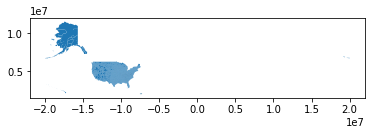

In [15]:
counties.plot()

In [16]:
counties.head()

,MTFCC,OID,GEOID,STATE,COUNTY,COUNTYNS,BASENAME,NAME,LSADC,FUNCSTAT,COUNTYCC,AREALAND,AREAWATER,OBJECTID,CENTLAT,CENTLON,INTPTLAT,INTPTLON,geometry,CountyFIPS,County,State,Percentage,Lower Limit,Upper Limit
0,G4020,27556109873712,30015,30,015,01719619,Chouteau,Chouteau County,06,A,H1,10288778621,62611691,1,+47.8806543,-110.4354426,+47.8868343,-110.4362004,"POLYGON ((-12315494.121 6143488.405, -12315265...",30015,Chouteau County,Montana,28.9,22.4,36.5
1,G4020,27556119101045,31017,31,017,00835830,Brown,Brown County,06,A,H1,3163296263,9814399,2,+42.4294932,-099.9293903,+42.3595618,-099.9239198,"POLYGON ((-11111319.574 5272855.550, -11111155...",31017,Brown County,Nebraska,38.5,32,45.3
2,G4020,27556136791559,47013,47,013,01639728,Campbell,Campbell County,06,A,H1,1243685301,46425148,3,+36.4034350,-084.1494562,+36.4015922,-084.1592495,"POLYGON ((-9386705.591 4354814.516, -9386736.2...",47013,Campbell County,Tennessee,32.7,25.1,41.1
3,G4020,27556177452845,37069,37,069,01008553,Franklin,Franklin County,06,A,H1,1273761672,7173998,4,+36.0827221,-078.2857435,+36.0882406,-078.2830903,"POLYGON ((-8728718.456 4324164.707, -8728364.7...",37069,Franklin County,North Carolina,36.1,27.1,45.8
4,G4020,27556165683114,24510,24,510,01702381,Baltimore,Baltimore city,25,F,C7,209649356,28758714,5,+39.3009639,-076.6106288,+39.3000324,-076.6104761,"POLYGON ((-8539486.120 4774265.314, -8539486.0...",24510,Baltimore City,Maryland,34.9,32.8,37.1


In [17]:
# remove Hawaii, Alaska, and Puerto Rico
no_AK = (counties['State'] != 'Alaska') 
no_HI = (counties['State'] != 'Hawaii') 
no_PR = (counties['State'] != 'Puerto Rico')
counties = counties[no_AK & no_HI & no_PR]

<AxesSubplot:>

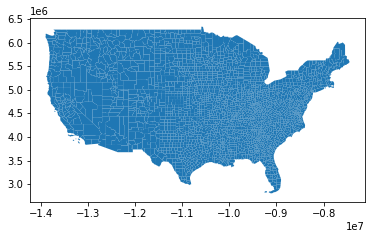

In [18]:
counties.plot()

## Exercise 3: Mapping and exploratory spatial data analysis (5 points)

<div class="alert alert-block alert-success">
       Exercise 3.1: Create a map to visually explore the obesity percentage variable. Where do you find clusters of the highest and lowest values?
</div>

<AxesSubplot:>

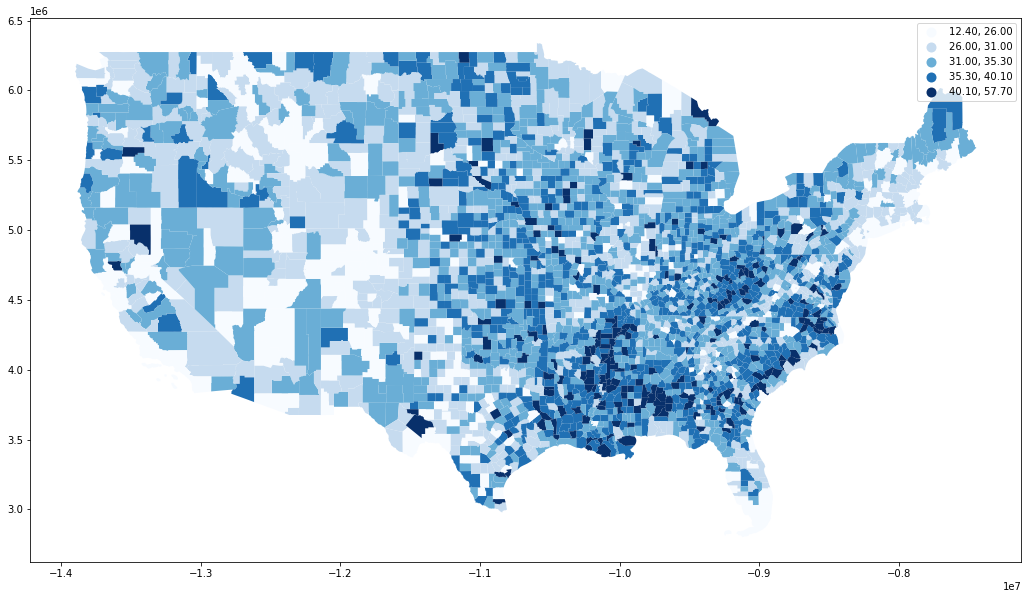

In [19]:
# plot obesity percentages (may need to convert type)
counties['Percentage'] = counties['Percentage'].astype(float)
counties.plot('Percentage', cmap = 'Blues', scheme = 'NaturalBreaks', legend = True, figsize = (20,10))

Visually, clusters of the highest values can be seen around the Southeast United States around Alabama. The lowest values seem to be clustered around the upper Colorado Basin. 

<div class="alert alert-block alert-success">
       Exercise 3.2: Next, create a Queen contiguity-based spatial weight matrix for the counties and assign it to a variable named 'qw'. Use the Queen spatial weight matrix to compute Moran's I for percent obesity. Print out the value of the I statistic and the p-value from the random permutation simulations. Does this variable have stasticically significant positive spatial autocorrelation (use 95% confidence)?

</div>

In [20]:
# create Queen spatial weight matrix
qw = sw.Queen.from_dataframe(counties)

In [21]:
# Morans I for percent obesity
qw.transform = 'r'
y = counties['Percentage']
m_obesity = Moran(y,qw)
print(m_obesity.I, m_obesity.p_sim)

0.37699476015077965 0.001


According to the p-value and the I statistic, there is a statistically significant positive spatial autocorrelation. The p-value also tells us that we can conclude this with 99.9% confidence (a higher confidence percentage than 95%).

<div class="alert alert-block alert-success">
       Exercise 3.2: Now, create a KNN spatial weight matrix (k=100) for the counties and assign it to a variable named 'kw'. Use the KNN spatial weight matrix to compute Moran's I for percent obesity. Print out the value of the I statistic and the p-value from the random permutation simulations. Does this variable have stasticically significant positive spatial autocorrelation? How Do these results compared to those attained above for the Queen weight matrix?
</div>

In [22]:
# create KNN spatial weight matrix
kw = KNN.from_dataframe(counties, k=100)

In [23]:
# Morans I for percent obesity
kw.transform = 'r'
k_obesity = Moran(y, kw)
print(k_obesity.I, k_obesity.p_sim)

0.24320682594235576 0.001


This variable also has statistically significant positive spatial autocorrelation. The I value indicates the autocorrelation is positive and the p-value indicates that we can reject the null hypothesis with 99.9% confidence. The only difference between the results from the Queen weight matrix and the KNN weight matrix is that the result from the I statistic when using the Queen weight matrix was higher than when using KNN. This is because the KNN spatial weight matrix includes 100 of the nearest neighbors to each county so it is picking up less clustering than the Queen spatial weight matrix that only considers the neighbors that are touching each county. 

<div class="alert alert-block alert-success">
       Exercise 3.3: For each of the spatial weight matrices created above, compute local Moran's I for percent obesity and plot the hot spots and cold spots on a single map. Where are the cold spots the most prominent and where are the hotspots the most prominent in each case and how do they differ? Critical thinking question: what is the difference between the two types of weights that cause these differences?
    
</div>

In [24]:
# compute local Moran's I for percent obesity using Queen W
import esda
queen_locali = esda.moran.Moran_Local(y, qw)

In [25]:
# plot hot spots and cold spots (use splot functions) using Queen W

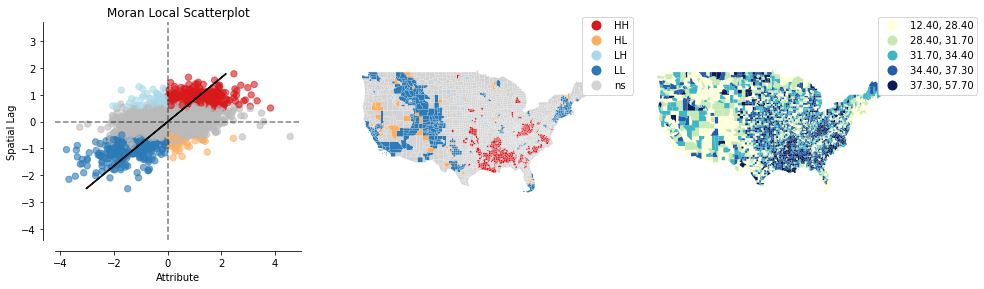

In [26]:
from splot import esda as esdaplot
lisa = esda.Moran_Local(counties['Percentage'], qw)
esdaplot.plot_local_autocorrelation(lisa, counties, 'Percentage');

In [27]:
# compute local Moran's I for percent obesity using KNN W
knn_locali= esda.moran.Moran_Local(y, kw)

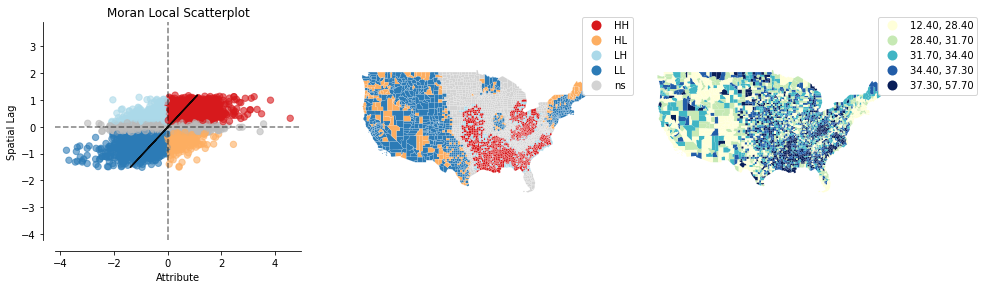

In [28]:
# plot hot spots and cold spots (use splot functions) using KNN W
lisa_knn = esda.Moran_Local(counties['Percentage'], kw)
esdaplot.plot_local_autocorrelation(lisa_knn, counties, 'Percentage');

Where are the cold spots the most prominent and where are the hotspots the most prominent in each case and how do they differ?


The cold spots are most prominent when using the queen spatial weight matrix in the western United States around the Montana, Colorado, and Wyoming region as well as the New England area. The cold spots are most prominent when using the KNN spatial weight matrix in the Western United States and New England area. The cold spots vary a lot between these two cases. When using the KNN, there is a much larger land area being covered because we set K=100 so it is including a lot more neighbors than the queen spatail weight matrix. 

The hot spots are most prominent when using the Queen spatial weight matrix in the Southern United States around Alabama, Louisiana, Mississippi, and some areas of Kentucky. The hot spots are are most prominent when using the KNN spatial weight matrix in the states along the Mississippi rivier, Kentucky, Tennessee, the Southeastern coastline, and Ohio. Similar to the cold spots, there is a much larger area that is included in the KNN hot spots than the Queen. 

Critical thinking question: what is the difference between the two types of weights that cause these differences?

The differences are occurring because these two spatial weights are calculated very differently. The queen spatial weight matrix defines a neighbor as a polygon that is touching a polygon of interest. However, we defined a neighbor in the KNN spatial weight matrix as being one of 100 closest polygons to a polygon of interest. Therefore, when using the KNN spatial weight matrix, there are more polygons that are classified as a neighbor compared to the queen spatial weight matrix. 

## Exercise 4: Create your own significance test using random permutation (3 points)

<div class="alert alert-block alert-success">
       Exercise 4.1: Randomly permute the values of obesity (use numpy.shuffle) and recompute Moran's I. Do this 100 times and save each I value. Plot a histogram of the I values and then plot the original I value as a red vertical line on top of the histogram. Where does the red line fall in relation to the bars of the histogram? Compute the number of times the I values from the 100 simulations are larger than the I value for the original data and divide this number by 100. What does this produce?
</div>

In [29]:
random = []

In [30]:
counties_copy = counties

In [31]:
column = counties_copy['Percentage']

In [32]:
for i in range(100):
    np.random.shuffle(counties_copy['Percentage'].values)
    mi = esda.moran.Moran(column,qw)
    value = mi.I
    random.append(value)

Text(0.5, 1.0, 'Morans I Distribution')

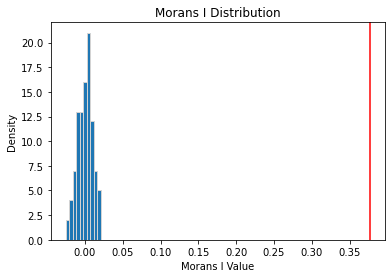

In [33]:
plt.hist(random, edgecolor = 'lightgrey', bins = 10)
plt.axvline(m_obesity.I, color = 'red')
plt.xlabel('Morans I Value')
plt.ylabel('Density')
plt.title('Morans I Distribution')

In comparison to the histogram, the red line falls at a much higher value. 

In [34]:
filtered = []

In [35]:
for i in random:
    if i > 0.37699476015077965:
        filtered.append(i)

In [36]:
print(len(filtered))

0


In [37]:
percent = len(filtered)/100
print(percent)

0.0


Essentially, these simulations can produce my own p-value and confidence interval. From the analysis above, I was able to determine that there are no random permutations that produced a Moran's I value that was greater than the value I obtained from the orginial data. I am not able to say with 100% certainty that this did not occur from a random pattern. However, since there were 100 random permutations and none produced a Moran's I value greater than the one from the original data, I can determine the p-value < 0.001 and the confidence interval > 99.9%. This means I can reject the null hypothesis that the pattern is random and I can accept the pattern is clustered.  

## Exercise 5: DIY analysis of spatial autocorrelation (3 points)

<div class="alert alert-block alert-success">
       Exercise 5.1: Load and analyze your own data. Pick a dataset with a spatial variable that is observed over 25 or more geographies. Create a spatial weights matrix of your choice and compute a global and local Moran's I. Plot the results and interpret them to consider the type of spatial autocorrelation present, it's statistical significance, and where different types of clusters exist.
</div>

In [38]:
texas_counties = gp.read_file('Texas Counties Map.geojson')

In [39]:
texas_income = pd.read_csv('Texas_income.csv', header = 0)

In [40]:
texas = pd.merge(texas_counties, texas_income, on = 'name')

<AxesSubplot:>

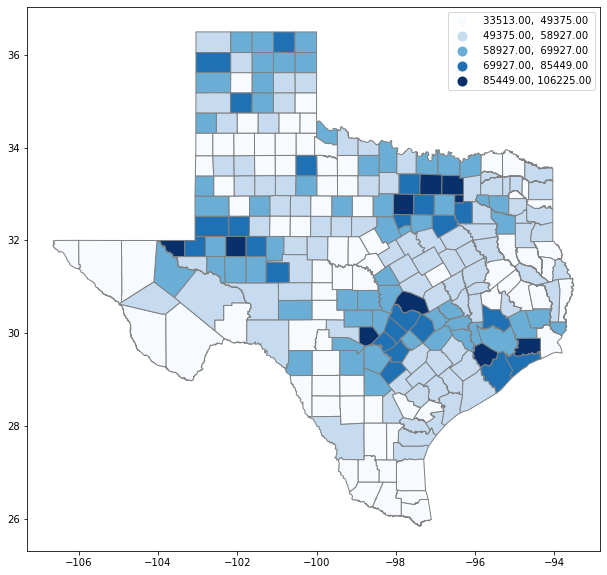

In [41]:
texas.plot('income', cmap = 'Blues', scheme = 'NaturalBreaks', legend = True, figsize = (20,10), edgecolor='grey')

In [42]:
texas_weight = sw.Queen.from_dataframe(texas)

In [43]:
texas_weight.transform = 'r'
interest = texas['income']
m_texas_income = Moran(interest,texas_weight)
print(m_texas_income.I, m_texas_income.p_sim)

0.4305658037298904 0.001


In [44]:
texas_local_i = esda.moran.Moran_Local(interest, texas_weight)

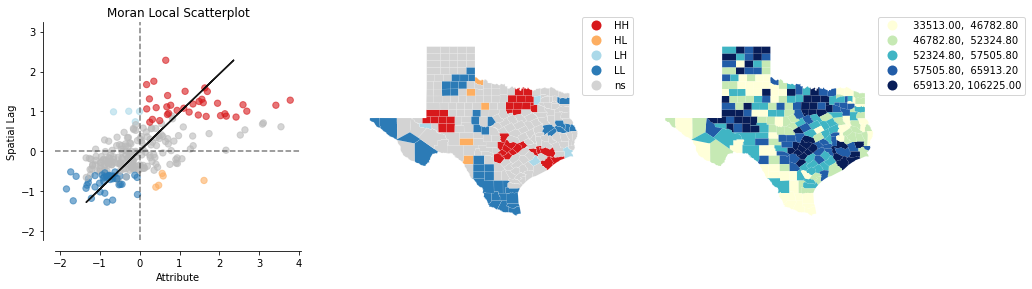

In [119]:
lisa_queen_texas = esda.Moran_Local(texas['income'], texas_weight)
esdaplot.plot_local_autocorrelation(lisa_queen_texas, texas, 'income');

From the scatterplot, I can conclude that there is positive spatial autocorrelation present in this data. This data is specifically looking at median household income among Texas counties. Therefore, if the data is positively spatially autocorrelated, there are clusters of low income areas next to other low income areas and high income areas next to other high income areas. When looking at the map of Texas and seeing the visual distribution, it is interesting how few outliers there are among the counties. In other words, it is not very common for there to be a high income county next to a low income county. In addition, the LL spatial clusters are, for the most part, in areas where Texas borders Mexico. However, HH income clusters are located near larger cities such as Dallas. 

## Exercise 6: Interpreting the K function (3 points)

<div class="alert alert-block alert-success">
       Exercise 6.1: Run the below cells of code to load in reports of graffiti across New York City and analyze them for spatial clustering using the K function. In the final figure, the blue line is the observed statistic and the orange line represents the expected value under the no hypothesis of complete spatial randomness. How do we interpret these results?

In [45]:
import pointpats as pp
%matplotlib inline
import matplotlib.pyplot as plt
from libpysal.cg import shapely_ext
from pointpats._deprecated_distance_statistics import K, Kenv

In [46]:
# load in the boundary data and create a window object
path_nybb = gp.datasets.get_path('nybb')
boros = gp.GeoDataFrame.from_file(path_nybb)

poly = shapely_ext.cascaded_union(boros.geometry)
win = pp.as_window(poly)

In [87]:
# load in the graffiti points data
fname = 'https://www.dropbox.com/s/md2g5bfw3itc69r/DSNY_Graffiti_Tracking.csv?dl=1'
grafitti = pd.read_csv(fname ,encoding='latin1', header=0)

In [88]:
# extract just the coordinate information and drop empty cells
grafitti = grafitti[['X_COORDINATE', 'Y_COORDINATE']]
grafitti = grafitti.dropna()
coords = grafitti.values

In [89]:
grafitti

,X_COORDINATE,Y_COORDINATE
1,999506.0,211952.0
2,1002889.0,218182.0
3,986069.0,201204.0
5,998362.0,212242.0
6,988723.0,204416.0
...,...,...
4518,990565.0,203683.0
4519,1031033.0,151997.0
4520,1023503.0,212865.0
4521,1027569.0,253485.0


In [50]:
# create point pattern object 
gpp = pp.PointPattern(coords, win)

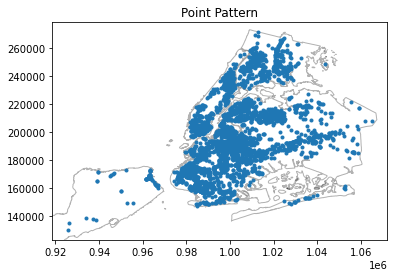

In [51]:
# plot them together
gpp.plot(window=True)

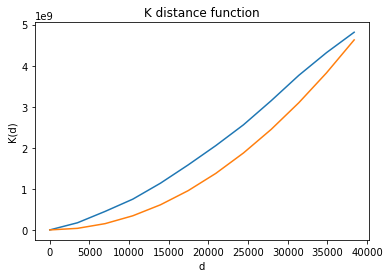

In [52]:
# Compute the K function and plot the results
k = K(gpp)
k.plot()

How do we interpret these results?

If the orange line is what was expected under the null hypothesis and blue is what was observed, we would be able to conclude that there is clustering of graffiti occuring. There were more points than expected in the computations which violated the null hypothesis that the graffiti is located in random locations.

<div class="alert alert-block alert-success">
       Exercise 6.2: Repeat the above analysis separately for each of the five boroughs of New York City. Report at what distances for each of the boroughs that there might be a repulsion pattern detected.

In [96]:
from shapely.geometry import Point, Polygon

Staten Island

In [97]:
Staten_island = boros.loc[boros['BoroName'] == 'Staten Island']

In [98]:
grafitti['geometry'] = [Point(grafitti.iloc[x]['X_COORDINATE'], grafitti.iloc[x]['Y_COORDINATE']) for x in range(len(grafitti))]
grafitti = gp.GeoDataFrame(grafitti, geometry = grafitti['geometry'])
grafitti.crs = boros.crs

In [99]:
staten_grafitti = grafitti[grafitti.within(Staten_island.unary_union)]

In [101]:
staten_grafitti

,X_COORDINATE,Y_COORDINATE,geometry
66,952838.0,149425.0,POINT (952838.000 149425.000)
112,963225.0,172770.0,POINT (963225.000 172770.000)
120,961838.0,166715.0,POINT (961838.000 166715.000)
163,952176.0,173117.0,POINT (952176.000 173117.000)
201,967202.0,160402.0,POINT (967202.000 160402.000)
...,...,...,...
4231,963437.0,167178.0,POINT (963437.000 167178.000)
4249,965111.0,164396.0,POINT (965111.000 164396.000)
4335,939029.0,165052.0,POINT (939029.000 165052.000)
4485,962889.0,167749.0,POINT (962889.000 167749.000)


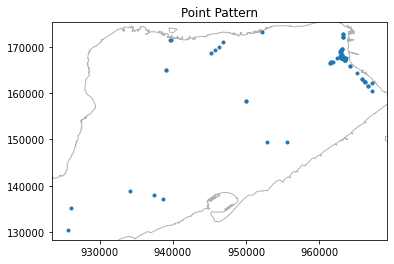

In [103]:
Staten_island_poly = shapely_ext.cascaded_union(Staten_island.geometry)
win_si = pp.as_window(Staten_island_poly)
gpp_si = pp.PointPattern(staten_grafitti, win_si)
gpp_si.plot(window = True)

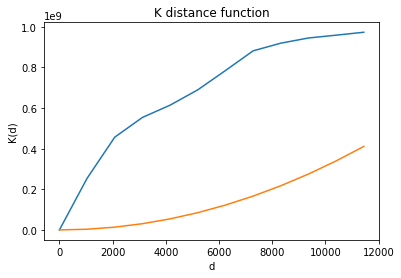

In [104]:
k_si = K(gpp_si)
k_si.plot()

According to the k distance function, there is no repulsion pattern detected for the grafitti points in Staten Island. 

Manhattan

In [105]:
Manhattan = boros.loc[boros['BoroName'] == 'Manhattan']

In [106]:
Manhattan_grafitti = grafitti[grafitti.within(Manhattan.unary_union)]

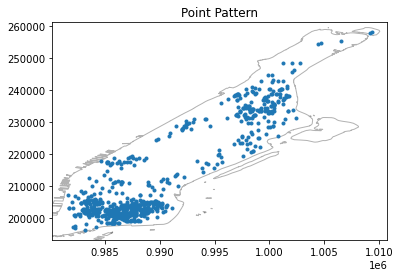

In [108]:
Manhattan_poly = shapely_ext.cascaded_union(Manhattan.geometry)
win_Manhattan = pp.as_window(Manhattan_poly)
gpp_Manhattan = pp.PointPattern(Manhattan_grafitti, win_Manhattan)
gpp_Manhattan.plot(window = True)

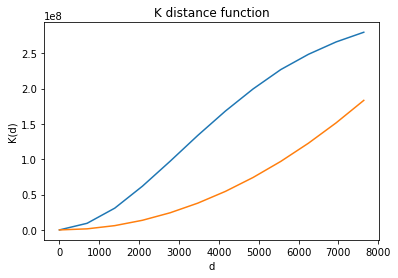

In [109]:
k_Manhattan = K(gpp_Manhattan)
k_Manhattan.plot()

According to the k distance function, there is no repulsion pattern detected for the grafitti points in Manhattan. There is actually a clustering pattern detected. 

Queens

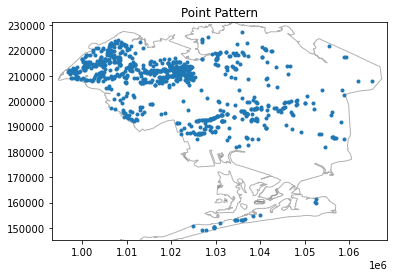

In [111]:
Queens = boros.loc[boros['BoroName'] == 'Queens']
Queens_grafitti = grafitti[grafitti.within(Queens.unary_union)]
Queens_poly = shapely_ext.cascaded_union(Queens.geometry)
win_Queens = pp.as_window(Queens_poly)
gpp_Queens = pp.PointPattern(Queens_grafitti, win_Queens)
gpp_Queens.plot(window = True)

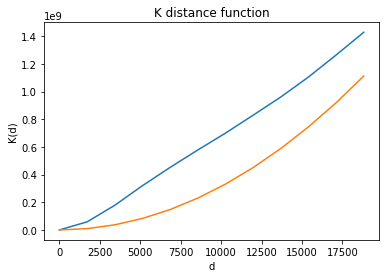

In [112]:
k_Queens = K(gpp_Queens)
k_Queens.plot()

According to the k distance function, there is no repulsion pattern detected for the grafitti points in Queens. There is actually a clustering pattern detected. 

Brooklyn

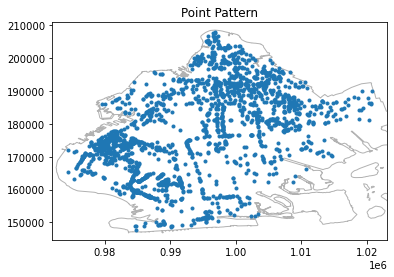

In [114]:
Brooklyn = boros.loc[boros['BoroName'] == 'Brooklyn']
Brooklyn_grafitti = grafitti[grafitti.within(Brooklyn.unary_union)]
Brooklyn_poly = shapely_ext.cascaded_union(Brooklyn.geometry)
win_Brooklyn = pp.as_window(Brooklyn_poly)
gpp_Brooklyn = pp.PointPattern(Brooklyn_grafitti, win_Brooklyn)
gpp_Brooklyn.plot(window = True)

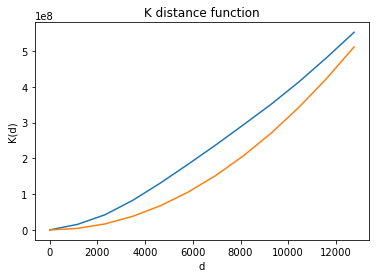

In [115]:
k_Brooklyn = K(gpp_Brooklyn)
k_Brooklyn.plot()

According to the k distance function, there are no distances where there is a repulsion pattern detected in Brooklyn.

Bronx

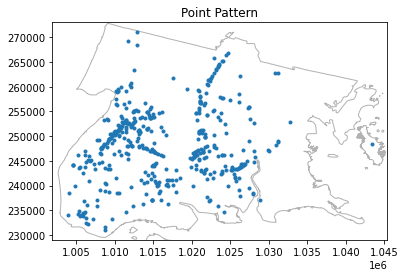

In [117]:
Bronx = boros.loc[boros['BoroName'] == 'Bronx']
Bronx_grafitti = grafitti[grafitti.within(Bronx.unary_union)]
Bronx_poly = shapely_ext.cascaded_union(Bronx.geometry)
win_Bronx = pp.as_window(Bronx_poly)
gpp_Bronx = pp.PointPattern(Bronx_grafitti, win_Bronx)
gpp_Bronx.plot(window = True)

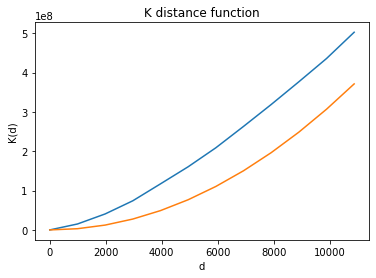

In [118]:
k_Bronx = K(gpp_Bronx)
k_Bronx.plot()

According to the k distance function, there are no distances in the Bronx where a repulsion pattern is detected. 